In [1]:
from pickle import load
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from chainconsumer import ChainConsumer

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from anstey.generate import T_CMB
from src.spherical_harmonics import RealSphericalHarmonics, calc_spherical_harmonic_matrix
from src.nregions_models import pix_forward_model_pl, genopt_pix_forward_model_pl
from src.blockmat import BlockMatrix, BlockVector
RS = RealSphericalHarmonics()
from nregions_inference import nuarr
import nregions_inference as NRI
from scipy.optimize import curve_fit
from functools import partial

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler

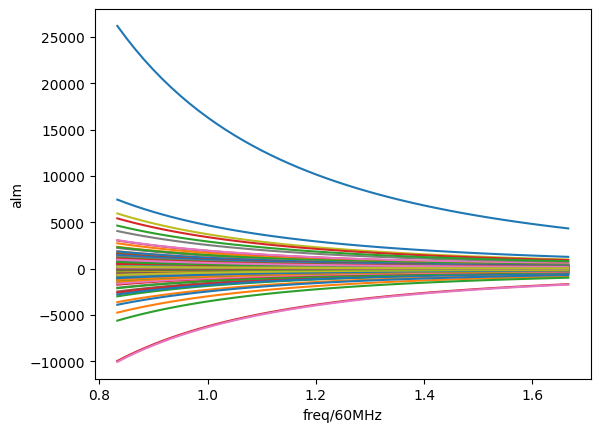

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_7345/1896924840.py:12: RuntimeWarning: invalid value encountered in log
  _=plt.plot(np.log(nuarr/60), np.log(a_sep))


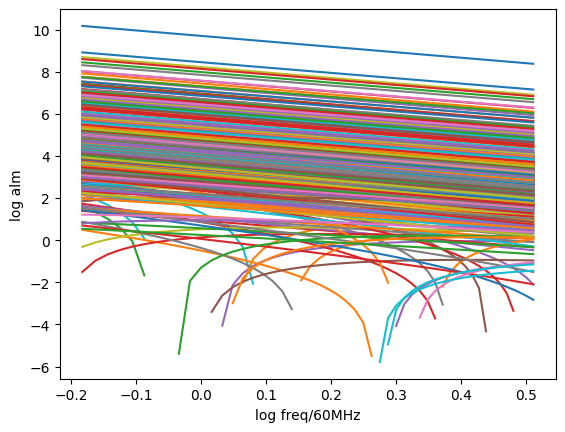

In [2]:
# Have a peek at the alm of the GSMA sky.
lmax  = 32
lmod  = 32
nside = 16
nuarr = NRI.nuarr
a = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmod, nside=nside, use_mat_Y=True)
a_sep = np.split(a, len(nuarr))
_=plt.plot(nuarr/60, a_sep)
plt.xlabel("freq/60MHz")
plt.ylabel("alm")
plt.show()
_=plt.plot(np.log(nuarr/60), np.log(a_sep))
plt.xlabel("log freq/60MHz")
plt.ylabel("log alm")
plt.show()

In [3]:
a_sep = np.array(a_sep)
a_sep.shape

(51, 1089)

In [4]:
# Make a function that takes a vector of components c and reconstructs an alm polynomial from it.
def alm_forward_model(nuarr, *c):
    A, alpha = c[:2]
    zetas    = c[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    alm_term = A*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return alm_term

# Make a function that takes one alm and regresses it to find the polynomial coefficients 
# up to a requested value.
def regress_powerlaw(nuarr, alm, Npoly=2):
    """
    Assuming that alm = A(nu/60)^alpha exp(zeta_0 log(nuarr/60)^2 + zeta_1 log(nuarr/60)^3 + ...)
    find the vector of values c=(A, alpha, zeta_0, ...) up to Npoly total terms.

    This can deal with negative alm functions.
    """
    assert Npoly >= 2
    
    # Guess at the initial parameters
    if np.all(alm>0):
        p0 = [np.exp(7), 2.5] + [0.001]*(Npoly-2)
    elif np.all(alm<0):
        p0 = [-np.exp(7), 2.5] + [0.001]*(Npoly-2)
    else:
        return 0

    fit, cov = curve_fit(alm_forward_model, nuarr, alm, p0=p0)

    return fit, cov

c, cov = regress_powerlaw(nuarr=nuarr, alm=a_sep[:,0], Npoly=2)

In [5]:
alm_reconstructed = alm_forward_model(nuarr, *c)

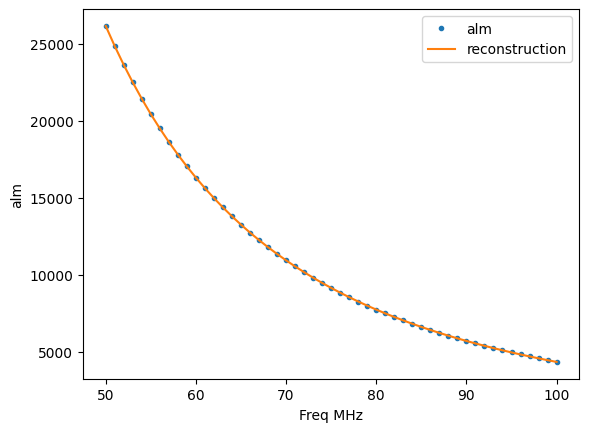

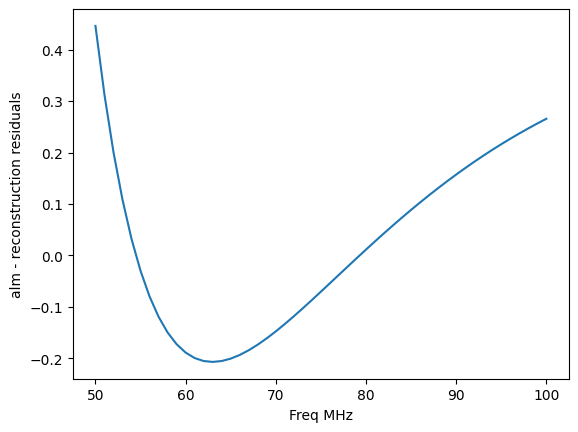

In [6]:
plt.plot(nuarr,a_sep[:,0], '.', label='alm')
plt.plot(nuarr,alm_reconstructed, label='reconstruction')
plt.xlabel("Freq MHz")
plt.ylabel("alm")
plt.legend()
plt.show()

plt.plot(nuarr,a_sep[:,0]-alm_reconstructed)
plt.xlabel("Freq MHz")
plt.ylabel("alm - reconstruction residuals")
plt.show()

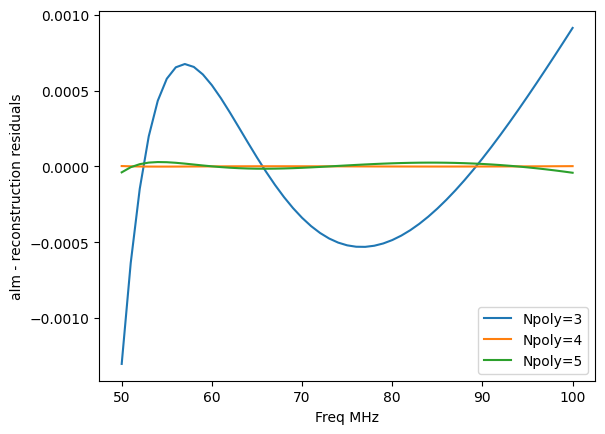

In [7]:
for Npoly in range(3, 6):
    c, cov = regress_powerlaw(nuarr=nuarr, alm=a_sep[:,0], Npoly=Npoly)
    alm_reconstructed = alm_forward_model(nuarr, *c)
    plt.plot(nuarr,a_sep[:,0]-alm_reconstructed, label=f"Npoly={Npoly}")
plt.legend()
plt.xlabel("Freq MHz")
plt.ylabel("alm - reconstruction residuals")
plt.show()

In [8]:
# Now use these functions to make a function that will fit the first lmod alms in this way.
def fit_alms(alm_list, Npoly=4):
    alm_list = a_sep.T
    fitlist = []
    for i, alm in enumerate(alm_list):
        try:
            fit, _ = regress_powerlaw(nuarr, alm, Npoly=Npoly)
        except:
            print(f"Error: cannot fit {i} as it has a zero-crossing, skipping it for now.")
        fitlist.append(fit)
    return np.array(fitlist)

In [9]:
fitlist=fit_alms(alm_list=a_sep.T, Npoly=4)

Error: cannot fit 102 as it has a zero-crossing, skipping it for now.
Error: cannot fit 174 as it has a zero-crossing, skipping it for now.
Error: cannot fit 189 as it has a zero-crossing, skipping it for now.
Error: cannot fit 251 as it has a zero-crossing, skipping it for now.
Error: cannot fit 289 as it has a zero-crossing, skipping it for now.
Error: cannot fit 317 as it has a zero-crossing, skipping it for now.
Error: cannot fit 331 as it has a zero-crossing, skipping it for now.
Error: cannot fit 353 as it has a zero-crossing, skipping it for now.
Error: cannot fit 391 as it has a zero-crossing, skipping it for now.
Error: cannot fit 414 as it has a zero-crossing, skipping it for now.
Error: cannot fit 441 as it has a zero-crossing, skipping it for now.
Error: cannot fit 445 as it has a zero-crossing, skipping it for now.
Error: cannot fit 473 as it has a zero-crossing, skipping it for now.
Error: cannot fit 531 as it has a zero-crossing, skipping it for now.
Error: cannot fit 54

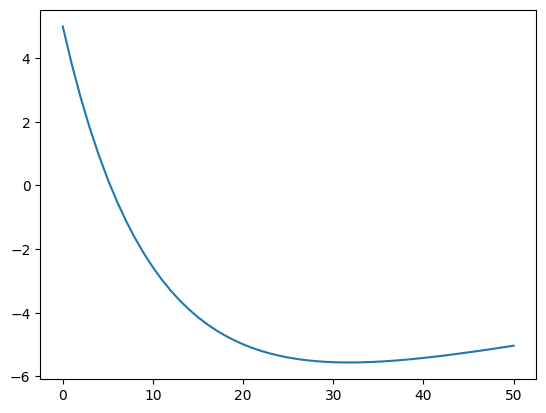

In [10]:
plt.plot(a_sep.T[102])

In [11]:
RS.get_lm(102)

(10, -8)

calc_spherical_harmonic_matrix npix, nalm : 3072 55
calc_spherical_harmonic_matrix npix, nalm : 3072 55
calc_spherical_harmonic_matrix npix, nalm : 3072 55


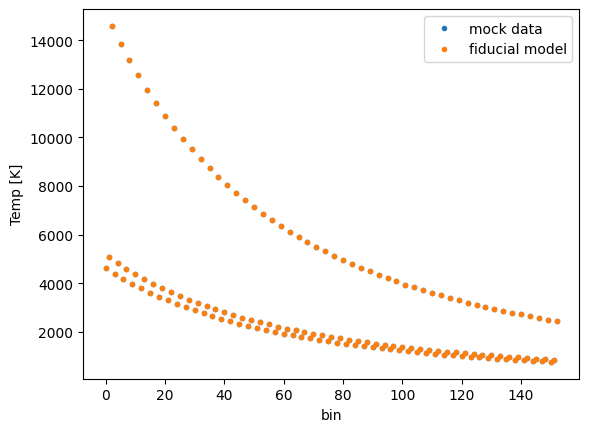

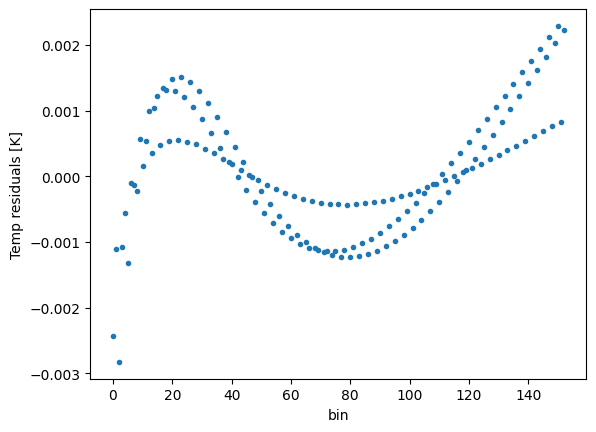

In [12]:
# Let's now generate some data with lmax = 2 and lmod = 2, and see if we can match things in data space.
lmax  = 9
nside = 16
times = np.linspace(0, 6, 3)
noise = 0.0
dnoisy, noise_covar, mat_A, mat_Y, params = NRI.fiducial_obs(
    uniform_noise=True,
    unoise_K = noise,
    times = times,
    Ntau = len(times),
    lmax = lmax,
    nside = nside
)
derr = np.sqrt(np.diag(noise_covar.matrix))
plt.plot(dnoisy.vector, '.', label='mock data')
plt.xlabel("bin")
plt.ylabel("Temp [K]")


# "Cheating" to get the exact values of the polynomial parameters we need to fit things by directly fitting the
# fiducial map.
lmod  = lmax
Npoly = 3
nuarr = NRI.nuarr
a = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmod, nside=nside, use_mat_Y=True)
a_sep = np.array(np.split(a, len(nuarr)))

fitlist=fit_alms(alm_list=a_sep.T, Npoly=Npoly)

# Evaluating the model at the fiducial parameter set.
mod = FM.generate_alm_pl_forward_model(nuarr, observation_mat=mat_A, Npoly=Npoly, lmax=lmod)
dmod = mod(fitlist.flatten())
plt.plot(dmod.vector, '.', label='fiducial model')
plt.legend()
plt.show()

plt.errorbar(list(range(len(dnoisy.vector))),dnoisy.vector-dmod.vector, yerr=derr,fmt='.')
plt.xlabel("bin")
plt.ylabel("Temp residuals [K]")
plt.show()

calc_spherical_harmonic_matrix npix, nalm : 3072 15
calc_spherical_harmonic_matrix npix, nalm : 3072 15
calc_spherical_harmonic_matrix npix, nalm : 3072 6
calc_spherical_harmonic_matrix npix, nalm : 3072 6
calc_spherical_harmonic_matrix npix, nalm : 3072 6


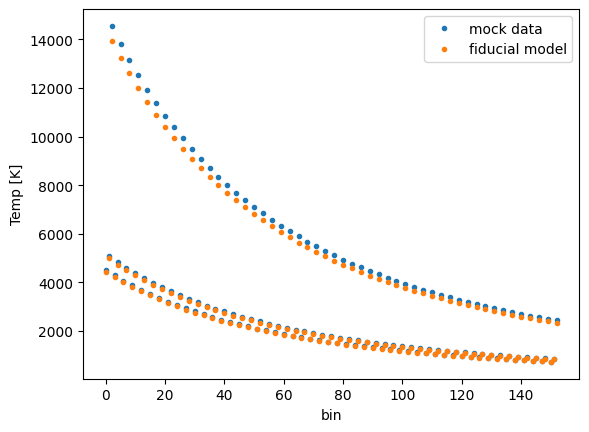

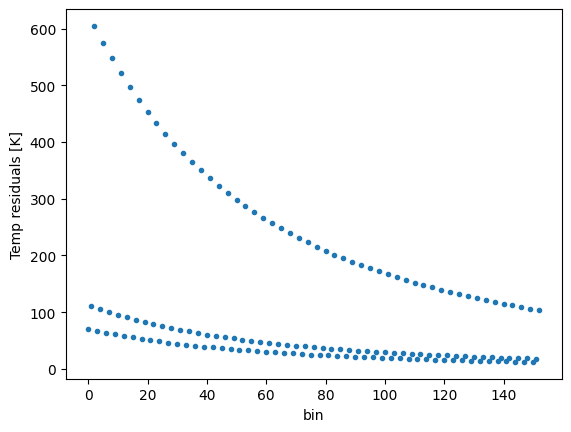

In [15]:
# Let's now generate some data with lmax != lmod, and see if we can match things in data space.
lmax  = 4
nside = 16
times = np.linspace(0, 6, 3)
noise = 0.00
dnoisy, noise_covar, mat_A, mat_Y, params = NRI.fiducial_obs(
    uniform_noise=True,
    unoise_K = noise,
    times = times,
    Ntau = len(times),
    lmax = lmax,
    nside = nside
)
derr = np.sqrt(np.diag(noise_covar.matrix))
plt.plot(dnoisy.vector, '.', label='mock data')
plt.xlabel("bin")
plt.ylabel("Temp [K]")


# "Cheating" to get the exact values of the polynomial parameters we need to fit things by directly fitting the
# fiducial map.
lmod  = 2
Npoly = 3
nuarr = NRI.nuarr
_, _, mat_A_mod, _, _ = NRI.fiducial_obs(
    uniform_noise=True,
    unoise_K = noise,
    times = times,
    Ntau = len(times),
    lmax = lmod,
    nside = nside
)
a = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmod, nside=nside, use_mat_Y=True)
a_sep = np.array(np.split(a, len(nuarr)))

fitlist=fit_alms(alm_list=a_sep.T, Npoly=Npoly)

# Evaluating the model at the fiducial parameter set.
mod = FM.generate_alm_pl_forward_model(nuarr, observation_mat=mat_A_mod, Npoly=Npoly, lmax=lmod)
dmod = mod(fitlist.flatten())
plt.plot(dmod.vector, '.', label='fiducial model')
plt.legend()
plt.show()

plt.errorbar(list(range(len(dnoisy.vector))),dnoisy.vector-dmod.vector, yerr=derr,fmt='.')
plt.xlabel("bin")
plt.ylabel("Temp residuals [K]")
plt.show()